In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
import shutil
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from sklearn.metrics import classification_report, confusion_matrix


# Define paths
data_dir = '/content/drive/My Drive/dataset_16'

# Define a function to split data into train and validation sets
def split_data(data_dir, val_ratio=0.2):
    classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
    for cls in classes:
        cls_dir = os.path.join(data_dir, cls)
        images = os.listdir(cls_dir)
        random.shuffle(images)
        val_count = int(len(images) * val_ratio)

        train_dir = os.path.join(data_dir, 'train', cls)
        val_dir = os.path.join(data_dir, 'val', cls)

        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)

        for img in images[val_count:]:
            shutil.move(os.path.join(cls_dir, img), os.path.join(train_dir, img))
        for img in images[:val_count]:
            shutil.move(os.path.join(cls_dir, img), os.path.join(val_dir, img))

# Split the data
split_data(data_dir)

# Define image size and batch size
image_size = (224, 224)
batch_size = 32

# Define ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(data_dir, 'train'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    directory=os.path.join(data_dir, 'val'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Print out some data statistics
print('Num training images: ', train_generator.samples)
print('Num validation images: ', val_generator.samples)

learning_rate = 0.001
base_model = Xception(weights='imagenet', include_top=False, pooling='max')
x = base_model.output
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # Update to match the number of classes in your dataset

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adamax(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

# Evaluate the model
val_loss, val_acc = model.evaluate(val_generator)
print('Validation loss:', val_loss)
print('Validation accuracy:', val_acc)

# Generate predictions and classification report
val_generator.reset()
Y_pred = model.predict(val_generator, steps=val_generator.samples // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes

# Generate classification report
class_labels = list(val_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_labels))

# Optionally, you can also print the confusion matrix
print(confusion_matrix(y_true, y_pred))


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Num training images:  384
Num validation images:  96
83683744/83683744 [==============================] - 1s 0us/step
Epoch 1/10
12/12 [==============================] - 380s 30s/step - loss: 1.7869 - accuracy: 0.4714 - val_loss: 0.9585 - val_accuracy: 0.5417
Epoch 2/10
12/12 [==============================] - 334s 28s/step - loss: 0.8293 - accuracy: 0.7552 - val_loss: 0.8029 - val_accuracy: 0.6562
Epoch 3/10
12/12 [==============================] - 334s 28s/step - loss: 0.5260 - accuracy: 0.7995 - val_loss: 0.8093 - val_accuracy: 0.6458
Epoch 4/10
12/12 [==============================] - 334s 28s/step - loss: 0.3808 - accuracy: 0.8854 - val_loss: 0.7678 - val_accuracy: 0.6979
Epoch 5/10
12/12 [==============================] - 333s 28s/step - loss: 0.3525 - accuracy: 0.9062 - val_loss: 0.6506 - val_accuracy: 0.7083
Epoch 6/10
12/12 [==============================] - 333s 28s/step - loss: 0.1940 - accuracy

4/4 [==============================] - 20s 4s/step
              precision    recall  f1-score   support

      glioma       0.22      0.25      0.24        24
  meningioma       0.23      0.29      0.25        24
     notumor       0.27      0.25      0.26        24
   pituitary       0.31      0.21      0.25        24

    accuracy                           0.25        96
   macro avg       0.26      0.25      0.25        96
weighted avg       0.26      0.25      0.25        96

[[6 7 7 4]
 [7 7 4 6]
 [8 9 6 1]
 [6 8 5 5]]


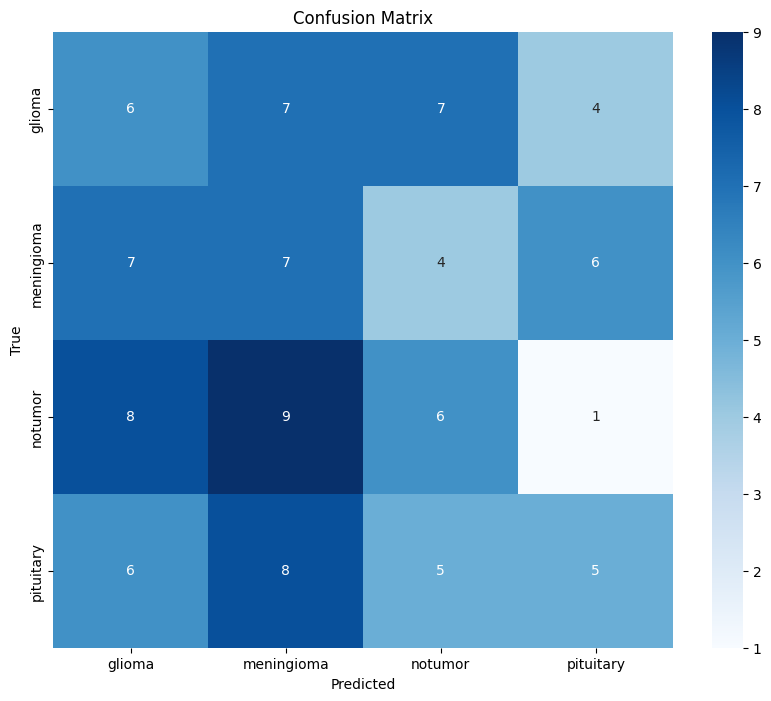

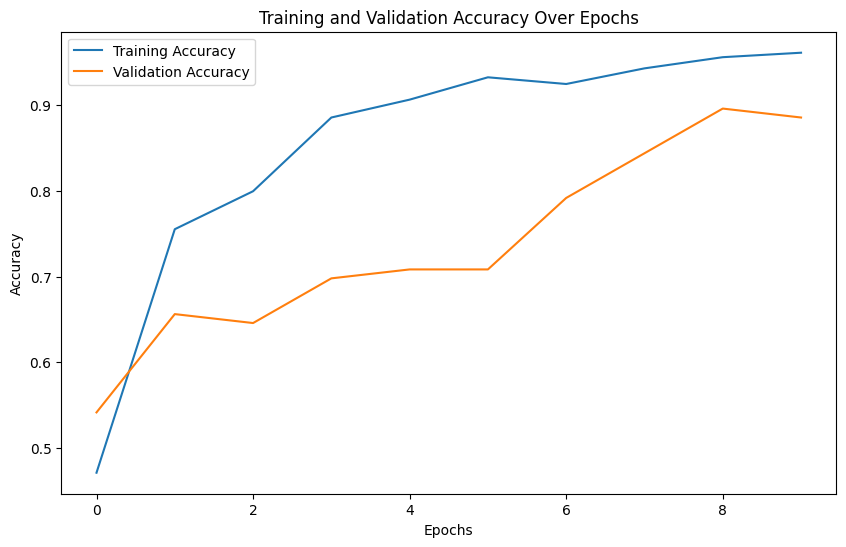

Epoch 1/10
3/3 [==============================] - 19s 6s/step

Epoch 1 F1 Score: 0.2007
12/12 [==============================] - 356s 30s/step - loss: 0.0844 - accuracy: 0.9714 - val_loss: 0.4447 - val_accuracy: 0.8542
Epoch 2/10
3/3 [==============================] - 20s 6s/step

Epoch 2 F1 Score: 0.2017
12/12 [==============================] - 352s 30s/step - loss: 0.1114 - accuracy: 0.9635 - val_loss: 0.5125 - val_accuracy: 0.8021
Epoch 3/10
3/3 [==============================] - 19s 6s/step

Epoch 3 F1 Score: 0.1856
12/12 [==============================] - 351s 29s/step - loss: 0.0812 - accuracy: 0.9661 - val_loss: 0.4791 - val_accuracy: 0.8125
Epoch 4/10
3/3 [==============================] - 18s 6s/step

Epoch 4 F1 Score: 0.2232
12/12 [==============================] - 353s 30s/step - loss: 0.0320 - accuracy: 0.9870 - val_loss: 0.4106 - val_accuracy: 0.8542
Epoch 5/10
3/3 [==============================] - 19s 6s/step

Epoch 5 F1 Score: 0.1462
12/12 [=============================

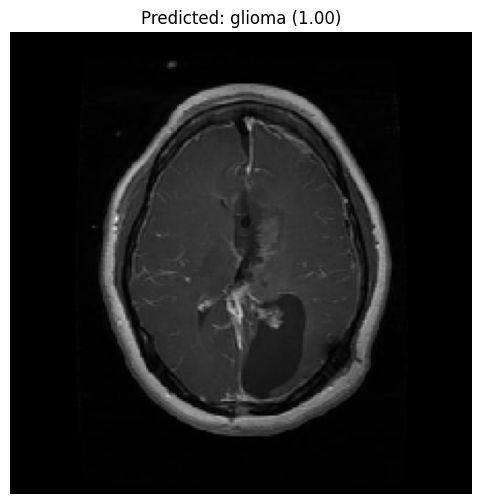

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import Callback

class F1ScoreCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_pred = np.argmax(self.model.predict(val_generator), axis=-1)
        val_true = val_generator.classes
        f1 = f1_score(val_true, val_pred, average='weighted')
        print(f'\nEpoch {epoch+1} F1 Score: {f1:.4f}')

f1_callback = F1ScoreCallback()
history = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[f1_callback])

from sklearn.metrics import precision_score

class PrecisionScoreCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_pred = np.argmax(self.model.predict(val_generator), axis=-1)
        val_true = val_generator.classes
        precision = precision_score(val_true, val_pred, average='weighted')
        print(f'\nEpoch {epoch+1} Precision Score: {precision:.4f}')

precision_callback = PrecisionScoreCallback()
history = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[precision_callback])

from sklearn.metrics import recall_score

class RecallScoreCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_pred = np.argmax(self.model.predict(val_generator), axis=-1)
        val_true = val_generator.classes
        recall = recall_score(val_true, val_pred, average='weighted')
        print(f'\nEpoch {epoch+1} Recall Score: {recall:.4f}')

recall_callback = RecallScoreCallback()
history = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[recall_callback])

def plot_prediction(image_path, model, class_labels):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]
    confidence_score = np.max(prediction)

    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class} ({confidence_score:.2f})')
    plt.axis('off')
    plt.show()

# Example usage
test_image_path = '/content/drive/My Drive/dataset_16/val/glioma/Te-gl_0032.jpg'
plot_prediction(test_image_path, model, class_labels)


3/3 [==============================] - 19s 6s/step


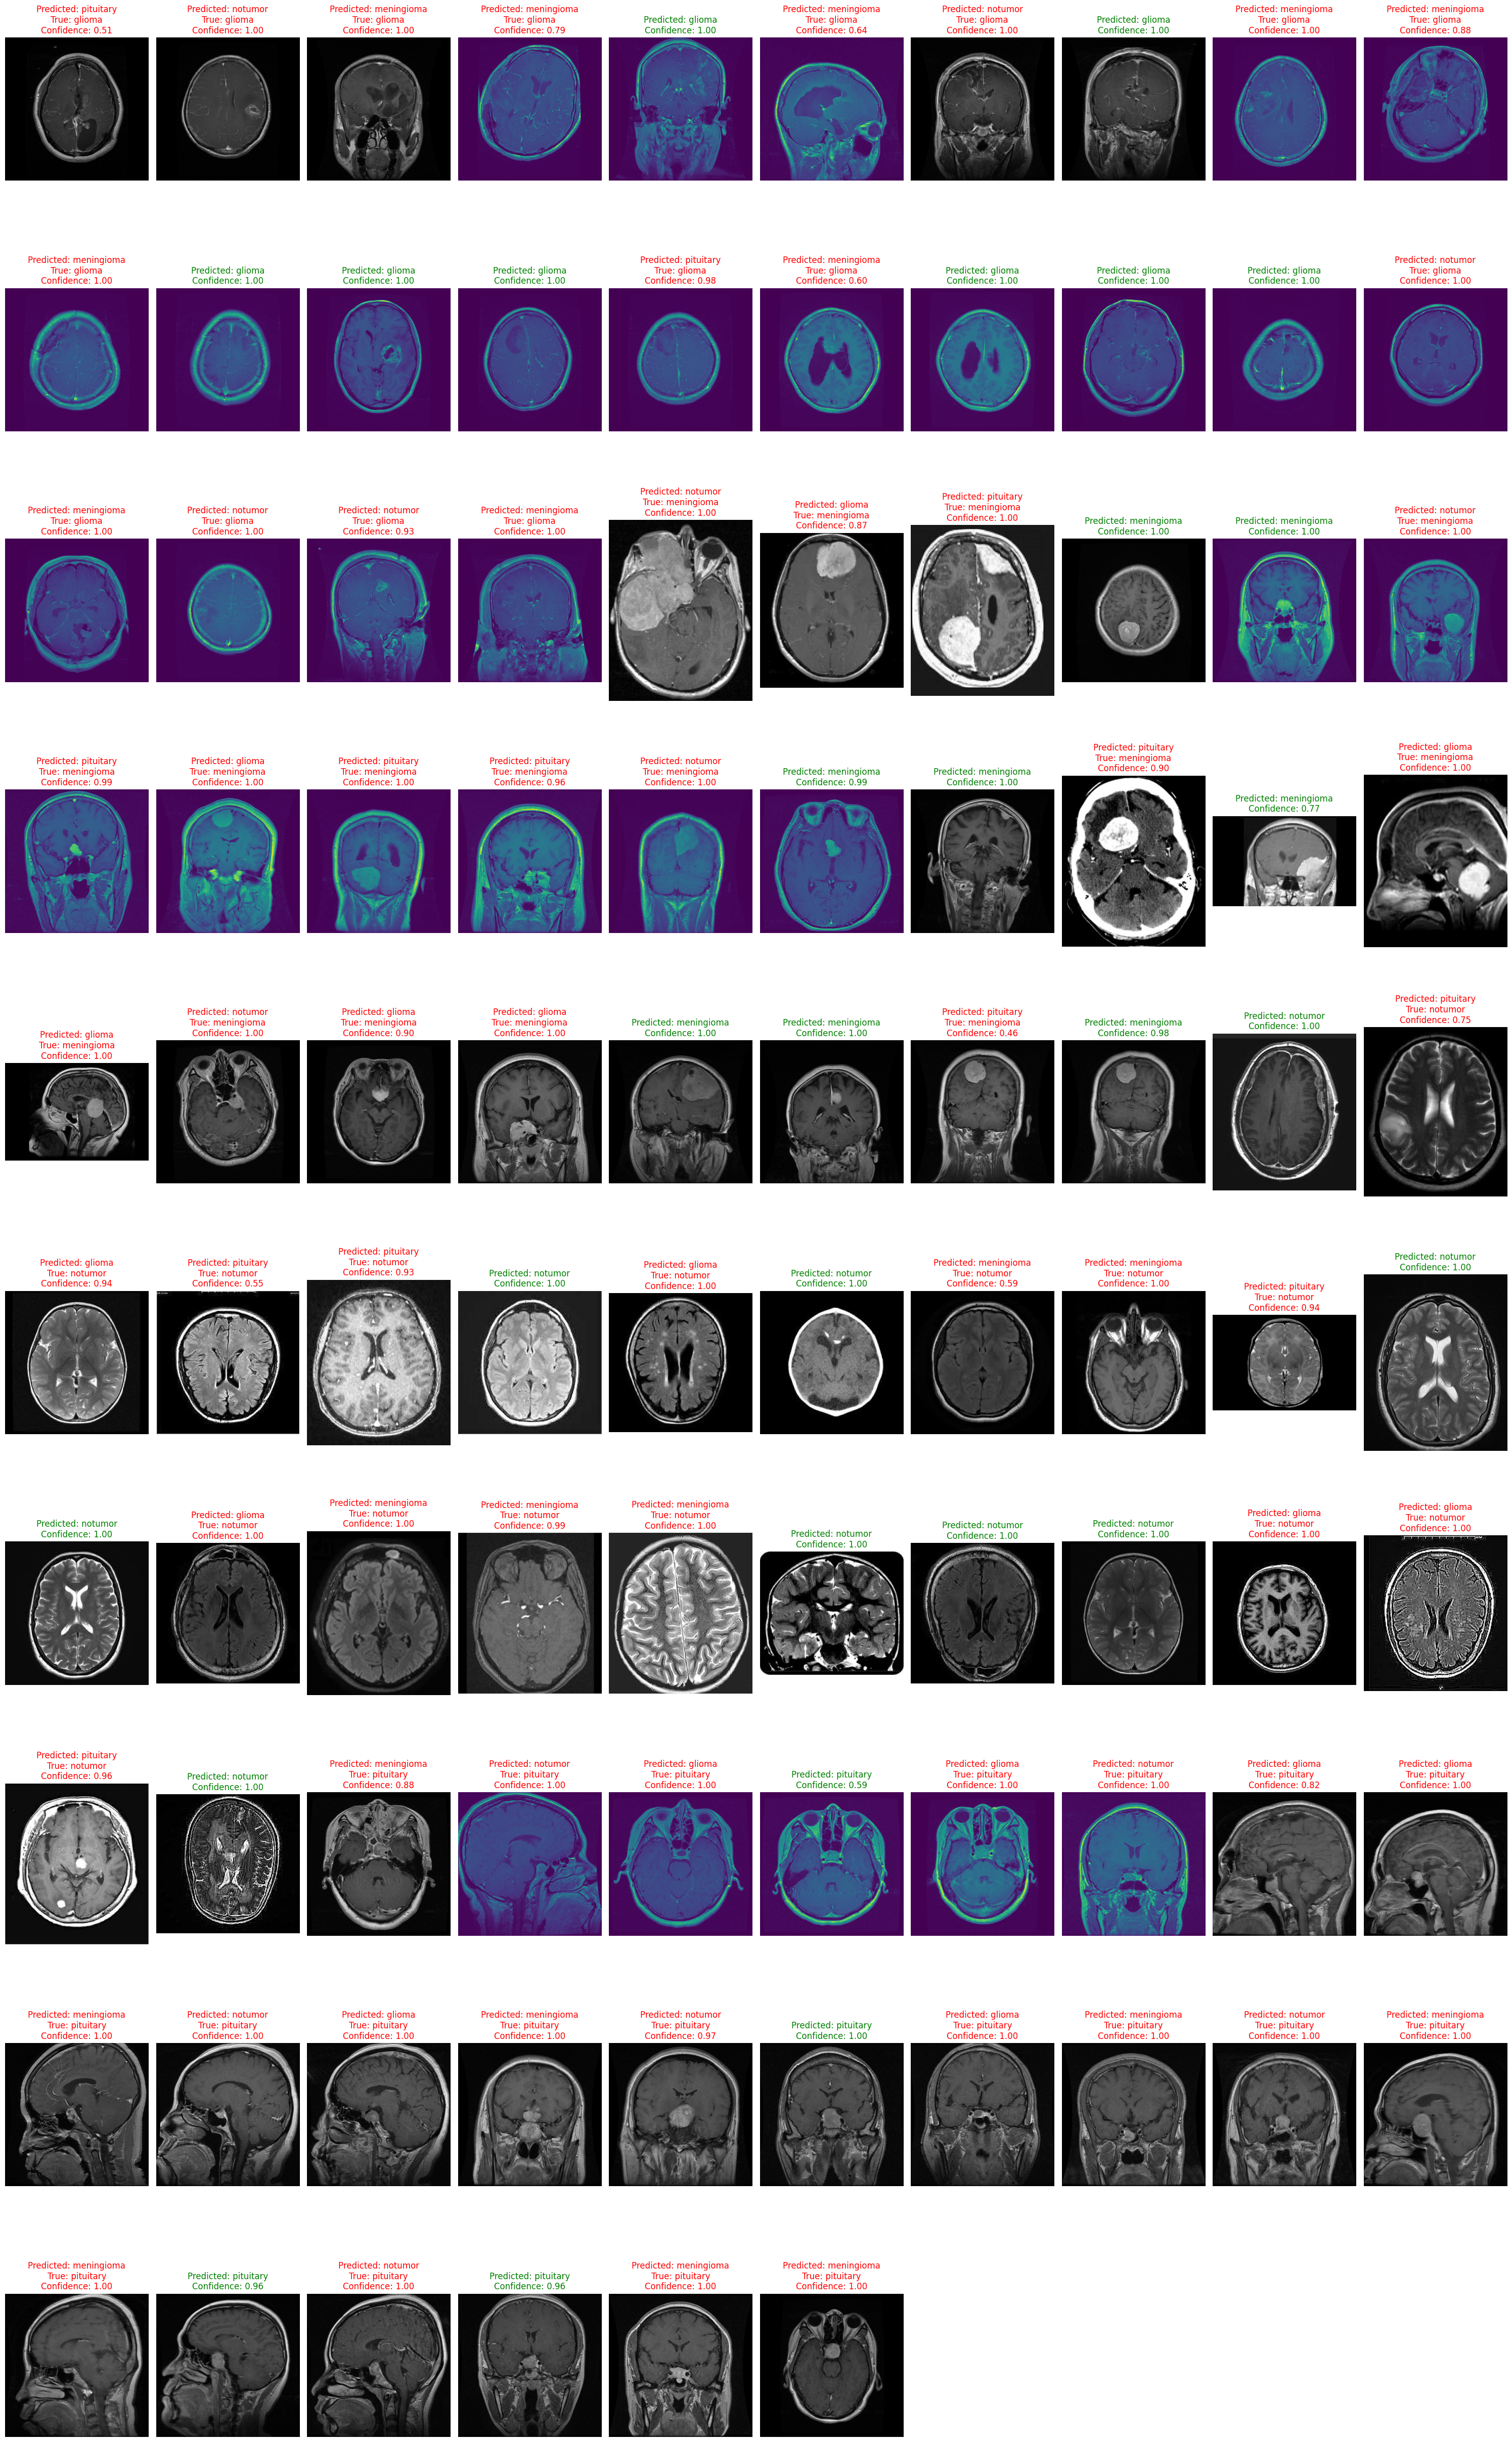

In [4]:
import matplotlib.pyplot as plt
import os

# Generate predictions
predictions = model.predict(val_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the class labels
class_labels = list(val_generator.class_indices.keys())

# Get the filenames and true labels from the validation generator
filenames = val_generator.filenames
true_labels = val_generator.classes

# Adjust the figure size and number of columns to accommodate all images
num_cols = 10
num_rows = (len(filenames) + num_cols - 1) // num_cols

plt.figure(figsize=(3 * num_cols, 5 * num_rows))

# Display a few test images with their predicted and true labels
for i in range(len(filenames)):
    plt.subplot(num_rows, num_cols, i + 1)
    img_path = os.path.join(data_dir, 'val', filenames[i])
    img = plt.imread(img_path)
    plt.imshow(img)

    # Determine prediction accuracy
    is_correct = class_labels[predicted_classes[i]] == class_labels[true_labels[i]]

    # Set title color based on prediction accuracy
    title_color = 'green' if is_correct else 'red'

    # Get the confidence score for the predicted class
    confidence = predictions[i][predicted_classes[i]]

    # Construct the title text
    if is_correct:
        title_text = f"Predicted: {class_labels[predicted_classes[i]]}\nConfidence: {confidence:.2f}"
    else:
        title_text = f"Predicted: {class_labels[predicted_classes[i]]}\nTrue: {class_labels[true_labels[i]]}\nConfidence: {confidence:.2f}"

    plt.title(title_text, color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()
